ROBUST BAYESIAN-TEMPORAL CORRELATED EQUILIBRIUM SIMULATION
With Fixed Indexing and Proper Constraints
✓ Loaded 40 policies
✓ Signal channels: ['s_logon_time', 's_logon_breadth', 's_role_change', 's_context_shift', 's_device_vol', 's_email_vol', 's_http_exfil', 's_file_sensitive', 's_net_scan', 's_term_access']
✓ Number of signal dimensions: 10

▶ Running simulation with 1000 users (10.0% malicious)...
▶ Analyzing results...
BAYESIAN-TEMPORAL CORRELATED EQUILIBRIUM - FINAL RESULTS

📊 DETECTION PERFORMANCE:
   • Precision:           1.0000
   • Recall:              1.0000
   • F1-Score:            1.0000
   • False Positive Rate: 0.0000
   • Mean Time to Detect: 39.34 days
   • Early Detection Rate: 0.00%

🔍 DETECTION BREAKDOWN:
   • Total Users:         1000
   • Malicious Users:     100 (10.0%)
   • True Positives:      100
   • False Positives:     0
   • False Negatives:     0
   • Early Detections:    0

👥 FINAL TYPE DISTRIBUTION:
   • Loyal:               582 users
   • Disgruntled

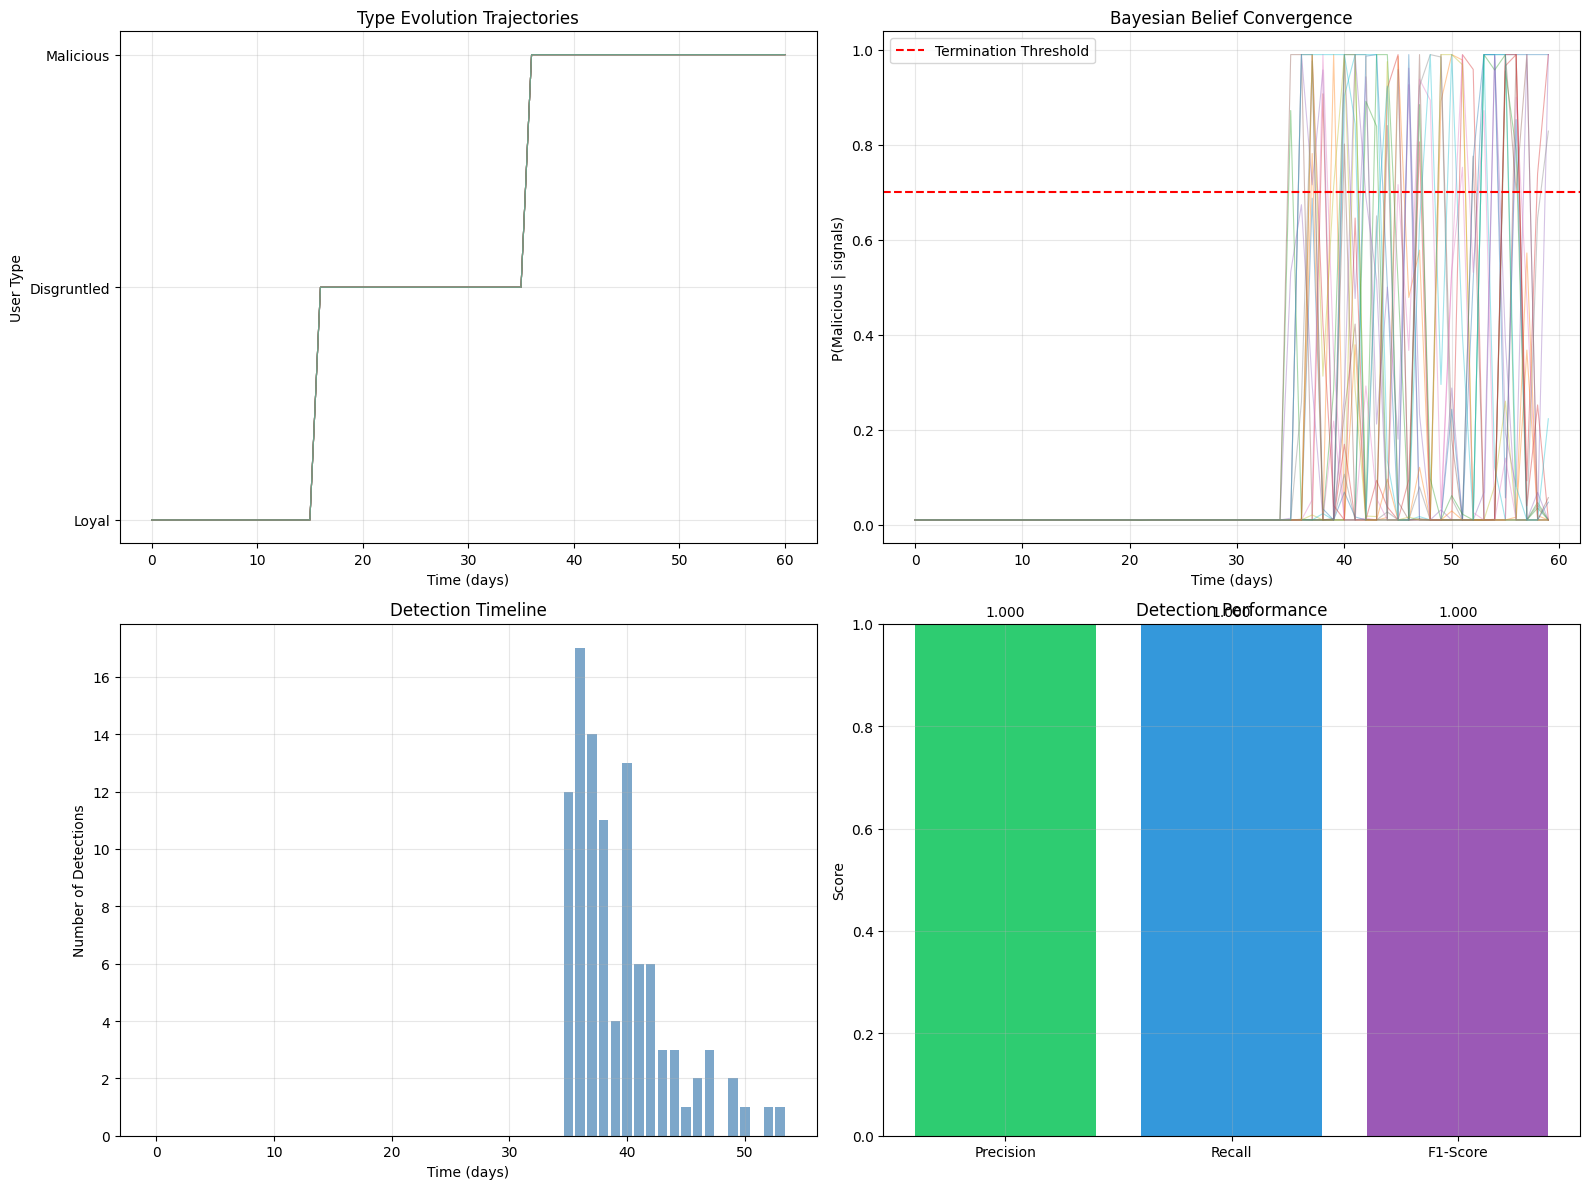


✓ Simulation completed successfully!
✓ Results saved to 'btce_results.png'


In [4]:
#!/usr/bin/env python3
"""
Bayesian-Temporal Correlated Equilibrium Simulation - FIXED INDEX ERROR
"""

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta
from dataclasses import dataclass
from typing import List, Dict, Tuple
from enum import Enum

# ============================================================================
# 1. ENUMS AND DATA STRUCTURES
# ============================================================================

class UserType(Enum):
    LOYAL = 0
    DISGRUNTLED = 1 
    MALICIOUS = 2

class InterventionLevel(Enum):
    NORMAL = 0
    ENHANCED_SCRUTINY = 1
    REVOKE_SENSITIVE = 2
    TERMINATE = 3

@dataclass
class Policy:
    id: str
    group: str
    category: str
    rule: str
    signal_channel: str
    severity: float
    rationale: str

@dataclass
class DetectionMetrics:
    precision: float
    recall: float
    f1_score: float
    false_positive_rate: float
    mean_time_to_detect: float
    early_detection_rate: float

# ============================================================================
# 2. CORRECTED TYPE EVOLUTION PROCESS
# ============================================================================

class CorrectedTypeEvolutionProcess:
    """
    FIXED: Type evolution that properly respects the malicious user constraint.
    """
    
    def __init__(self):
        # Honest users can only evolve between Loyal and Disgruntled
        self.honest_transitions = {
            UserType.LOYAL: {
                UserType.LOYAL: 0.95,
                UserType.DISGRUNTLED: 0.05,
                UserType.MALICIOUS: 0.00
            },
            UserType.DISGRUNTLED: {
                UserType.LOYAL: 0.10,
                UserType.DISGRUNTLED: 0.90,
                UserType.MALICIOUS: 0.00
            },
            UserType.MALICIOUS: {
                UserType.LOYAL: 0.00,
                UserType.DISGRUNTLED: 0.00,
                UserType.MALICIOUS: 1.00
            }
        }
    
    def evolve_type(self, current_type: UserType, is_malicious: bool, 
                   signals: np.ndarray, t: int) -> UserType:
        """
        CORRECTED: Type evolution that respects the malicious user constraint.
        """
        if not is_malicious:
            return self._evolve_honest(current_type)
        else:
            return self._evolve_malicious_strategic(current_type, signals, t)
    
    def _evolve_honest(self, current_type: UserType) -> UserType:
        """Honest users only evolve between Loyal and Disgruntled."""
        if current_type == UserType.MALICIOUS:
            return UserType.DISGRUNTLED
            
        probs = list(self.honest_transitions[current_type].values())
        next_type_idx = np.random.choice([0, 1, 2], p=probs)
        next_type = UserType(next_type_idx)
        
        if next_type == UserType.MALICIOUS:
            return UserType.DISGRUNTLED
            
        return next_type
    
    def _evolve_malicious_strategic(self, current_type: UserType, 
                                  signals: np.ndarray, t: int) -> UserType:
        """Malicious users follow three-phase strategic evolution."""
        composite_anomaly = np.mean(signals)
        
        if t < 15:  # Phase 1: Stealth
            if current_type == UserType.LOYAL and composite_anomaly > 0.4:
                return UserType.DISGRUNTLED
        elif t < 35:  # Phase 2: Reconnaissance
            if current_type == UserType.LOYAL:
                return UserType.DISGRUNTLED
            elif current_type == UserType.DISGRUNTLED and composite_anomaly > 0.6:
                return UserType.MALICIOUS
        else:  # Phase 3: Weaponization
            if current_type != UserType.MALICIOUS:
                return UserType.MALICIOUS
        
        return current_type

# ============================================================================
# 3. STRATEGIC USER BEHAVIOR (FIXED INDEXING)
# ============================================================================

class StrategicUserAgent:
    """Implements sophisticated Byzantine behavior with proper indexing."""
    
    def __init__(self, user_id: int, initial_type: UserType, policies: List[Policy],
                 channels: Dict[str, int], channel_severity: Dict[str, float],
                 is_malicious: bool = False):
        self.user_id = user_id
        self.current_type = initial_type
        self.policies = policies
        self.channels = channels
        self.channel_severity = channel_severity
        self.is_malicious = is_malicious
        self.n_signals = len(channels)
        
        # History tracking
        self.type_history = [initial_type]
        self.signal_history = []
        
        # Phase tracking (only for malicious users)
        self.attack_phase = "stealth" if is_malicious else "honest"
    
    def generate_signals(self, t: int) -> np.ndarray:
        """Generate signals based on user type and strategic intent."""
        if not self.is_malicious:
            return self._generate_honest_signals()
        
        # Malicious user strategic signal generation
        self._update_attack_phase(t)
        
        if self.attack_phase == "stealth":
            return self._stealth_phase_signals()
        elif self.attack_phase == "reconnaissance":
            return self._reconnaissance_phase_signals(t)
        else:  # weaponization
            return self._weaponization_phase_signals()
    
    def _update_attack_phase(self, t: int):
        """Update attack phase for malicious users only."""
        if not self.is_malicious:
            return
            
        if t < 15:
            self.attack_phase = "stealth"
        elif t < 35:
            self.attack_phase = "reconnaissance" 
        else:
            self.attack_phase = "weaponization"
    
    def _generate_honest_signals(self) -> np.ndarray:
        """Generate signals for honest users (low anomaly)."""
        signals = np.zeros(self.n_signals)
        for policy in self.policies:
            ch_idx = self.channels[policy.signal_channel]
            # Honest users: low beta parameters (2, 8)
            signal_val = np.random.beta(2, 8)
            severity_weight = self.channel_severity[policy.signal_channel]
            signals[ch_idx] = signal_val * severity_weight
        self.signal_history.append(signals)
        return signals
    
    def _stealth_phase_signals(self) -> np.ndarray:
        """Phase 1: Minimal signals, trust building."""
        signals = np.zeros(self.n_signals)
        for policy in self.policies:
            ch_idx = self.channels[policy.signal_channel]
            # Slightly elevated but still low signals
            signal_val = np.random.beta(3, 7)
            severity_weight = self.channel_severity[policy.signal_channel]
            signals[ch_idx] = signal_val * severity_weight
        self.signal_history.append(signals)
        return signals
    
    def _reconnaissance_phase_signals(self, t: int) -> np.ndarray:
        """Phase 2: Strategic probing."""
        signals = np.zeros(self.n_signals)
        
        for policy in self.policies:
            ch_idx = self.channels[policy.signal_channel]
            severity_weight = self.channel_severity[policy.signal_channel]
            
            if policy.category in ["Reconnaissance", "Privilege"]:
                signal_val = np.random.beta(6, 4)
            elif policy.category == "Access" and t % 7 == 0:
                signal_val = np.random.beta(5, 5) 
            else:
                signal_val = np.random.beta(3, 7)
                
            signals[ch_idx] = signal_val * severity_weight
        
        self.signal_history.append(signals)
        return signals
    
    def _weaponization_phase_signals(self) -> np.ndarray:
        """Phase 3: Weaponization - FIXED INDEXING."""
        signals = np.zeros(self.n_signals)
        
        # Choose primary exfiltration channel
        exfil_channels = ['s_device_vol', 's_email_vol', 's_http_exfil']
        chosen_channel = np.random.choice(exfil_channels)
        
        for policy in self.policies:
            ch_idx = self.channels[policy.signal_channel]
            severity_weight = self.channel_severity[policy.signal_channel]
            
            if policy.signal_channel == chosen_channel:
                signal_val = np.random.beta(8, 2)
            elif policy.category == "Exfiltration":
                signal_val = np.random.beta(5, 5)
            elif policy.category in ["Access", "Privilege"]:
                signal_val = np.random.beta(6, 4)
            else:
                signal_val = np.random.beta(4, 6)
                
            signals[ch_idx] = signal_val * severity_weight
        
        # FIXED: Ensure detection using proper channel indexing
        if signals.max() < 0.6:
            # Find the index of the chosen channel and boost that signal
            chosen_channel_idx = self.channels[chosen_channel]
            signals[chosen_channel_idx] = np.random.beta(8, 2) * self.channel_severity[chosen_channel]
        
        self.signal_history.append(signals)
        return signals
    
    def step(self, t: int, tep: CorrectedTypeEvolutionProcess) -> np.ndarray:
        """Execute one timestep with corrected type evolution."""
        signals = self.generate_signals(t)
        
        # CORRECTED: Type evolution respects malicious constraint
        self.current_type = tep.evolve_type(
            self.current_type, self.is_malicious, signals, t
        )
        self.type_history.append(self.current_type)
        
        return signals

# ============================================================================
# 4. BAYESIAN BELIEF SYSTEM (ROBUST)
# ============================================================================

class RobustCertifierAgent:
    def __init__(self, n_signals: int, channel_severity: Dict[str, float]):
        self.n_signals = n_signals
        self.channel_severity = list(channel_severity.values())
        self.belief_malicious = 0.05
        self.belief_history = []
        
        # Ensure we have enough likelihood parameters
        self.likelihood_params = []
        for i in range(n_signals):
            # Use appropriate parameters based on signal type
            if i < 6:  # Core signals from paper
                self.likelihood_params.append((2, 8, 8, 2))
            else:  # Additional signals
                self.likelihood_params.append((2, 8, 7, 3))
    
    def robust_bayesian_update(self, signals: np.ndarray) -> float:
        # Handle case where we have more signals than parameters
        effective_signals = min(self.n_signals, len(signals))
        
        log_prior_odds = np.log(self.belief_malicious) - np.log(1 - self.belief_malicious)
        log_likelihood_ratio = 0.0
        
        for i in range(effective_signals):
            if i >= len(self.likelihood_params):
                continue
                
            s = np.clip(signals[i], 1e-6, 1-1e-6)
            alpha_hon, beta_hon, alpha_mal, beta_mal = self.likelihood_params[i]
            
            # Use channel severity if available, otherwise default to 1.0
            severity = self.channel_severity[i] if i < len(self.channel_severity) else 1.0
            
            try:
                log_p_mal = beta.logpdf(s, alpha_mal, beta_mal)
                log_p_hon = beta.logpdf(s, alpha_hon, beta_hon)
                signal_contribution = severity * (log_p_mal - log_p_hon)
                log_likelihood_ratio += signal_contribution
            except:
                continue
        
        log_posterior_odds = log_prior_odds + log_likelihood_ratio
        
        if log_posterior_odds > 10:
            posterior_malicious = 0.99
        elif log_posterior_odds < -10:
            posterior_malicious = 0.01
        else:
            posterior_malicious = 1 / (1 + np.exp(-log_posterior_odds))
        
        self.belief_malicious = np.clip(posterior_malicious, 0.01, 0.99)
        self.belief_history.append(self.belief_malicious)
        return self.belief_malicious
    
    def compute_insider_threat_score(self, signals: np.ndarray) -> float:
        # Use equal weights for simplicity
        weights = np.ones(len(signals)) / len(signals)
        base_its = np.dot(weights, signals)
        
        # Add temporal component if we have history
        if len(self.belief_history) >= 2:
            belief_velocity = self.belief_malicious - self.belief_history[-1]
            temporal_boost = 0.3 * abs(belief_velocity)
        else:
            temporal_boost = 0
        
        return min(base_its + temporal_boost, 1.0)

# ============================================================================
# 5. GRADUATED INTERVENTION PROTOCOL
# ============================================================================

class GraduatedInterventionProtocol:
    def __init__(self):
        self.theta_1 = 0.2
        self.theta_2 = 0.5  
        self.theta_3 = 0.7
        self.theta_4 = 0.9
    
    def determine_intervention(self, belief: float, its: float) -> InterventionLevel:
        composite_risk = 0.7 * belief + 0.3 * its
        
        if composite_risk < self.theta_1:
            return InterventionLevel.NORMAL
        elif composite_risk < self.theta_2:
            return InterventionLevel.ENHANCED_SCRUTINY
        elif composite_risk < self.theta_3:
            return InterventionLevel.REVOKE_SENSITIVE
        else:
            return InterventionLevel.TERMINATE

# ============================================================================
# 6. ROBUST SIMULATION ENGINE
# ============================================================================

class RobustBTCESimulation:
    def __init__(self, policies_file: str):
        self.policies, self.channels, self.channel_severity = self.load_policies(policies_file)
        self.tep = CorrectedTypeEvolutionProcess()
        self.intervention_protocol = GraduatedInterventionProtocol()
        
        print(f"✓ Loaded {len(self.policies)} policies")
        print(f"✓ Signal channels: {list(self.channels.keys())}")
        print(f"✓ Number of signal dimensions: {len(self.channels)}")
    
    @staticmethod
    def load_policies(filepath: str) -> Tuple[List[Policy], Dict[str, int], Dict[str, float]]:
        with open(filepath, 'r') as f:
            policy_data = json.load(f)
        
        policies = [Policy(**p) for p in policy_data]
        
        channels = {}
        channel_severity = {}
        for p in policies:
            if p.signal_channel not in channels:
                channels[p.signal_channel] = len(channels)
                channel_severity[p.signal_channel] = []
            channel_severity[p.signal_channel].append(p.severity)
        
        for ch in channel_severity:
            channel_severity[ch] = np.mean(channel_severity[ch])
        
        return policies, channels, channel_severity
    
    def run_simulation(self, n_users: int = 1000, pct_malicious: float = 0.10, 
                      horizon: int = 60) -> Dict:
        n_malicious = int(n_users * pct_malicious)
        
        results = {
            "detected_users": [],
            "missed_users": [],
            "false_positives": [],
            "detection_days": [],
            "early_detections": 0,
            "type_evolutions": [],
            "belief_trajectories": [],
            "threat_scores": []
        }
        
        for user_id in range(n_users):
            is_malicious = user_id < n_malicious
            initial_type = UserType.LOYAL
            
            user = StrategicUserAgent(user_id, initial_type, self.policies, 
                                    self.channels, self.channel_severity, is_malicious)
            certifier = RobustCertifierAgent(len(self.channels), self.channel_severity)
            
            detected = False
            detection_day = None
            beliefs = []
            threat_scores = []
            
            for t in range(horizon):
                try:
                    signals = user.step(t, self.tep)
                    belief = certifier.robust_bayesian_update(signals)
                    its = certifier.compute_insider_threat_score(signals)
                    
                    beliefs.append(belief)
                    threat_scores.append(its)
                    
                    intervention = self.intervention_protocol.determine_intervention(belief, its)
                    
                    # Detection logic
                    if (intervention == InterventionLevel.TERMINATE and 
                        not detected and is_malicious):
                        detected = True
                        detection_day = t
                        results["detected_users"].append(user_id)
                        
                        if t < 35:
                            results["early_detections"] += 1
                    
                    # False positive
                    if (intervention == InterventionLevel.TERMINATE and 
                        not detected and not is_malicious):
                        results["false_positives"].append(user_id)
                        
                except Exception as e:
                    print(f"Warning: Error processing user {user_id} at time {t}: {e}")
                    continue
            
            # Post-user processing
            if is_malicious and not detected:
                results["missed_users"].append(user_id)
            
            if detection_day is not None:
                results["detection_days"].append(detection_day)
            
            results["type_evolutions"].append([t.value for t in user.type_history])
            results["belief_trajectories"].append(beliefs)
            results["threat_scores"].append(threat_scores)
        
        return results
    
    def analyze_results(self, results: Dict, n_users: int, pct_malicious: float) -> DetectionMetrics:
        n_malicious = int(n_users * pct_malicious)
        n_honest = n_users - n_malicious
        
        tp = len(results["detected_users"])
        fp = len(results["false_positives"])
        fn = len(results["missed_users"])
        tn = n_honest - fp
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / n_malicious if n_malicious > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        fpr = fp / n_honest if n_honest > 0 else 0
        
        mttd = np.mean(results["detection_days"]) if results["detection_days"] else 0
        early_detection_rate = results["early_detections"] / n_malicious if n_malicious > 0 else 0
        
        return DetectionMetrics(
            precision=precision,
            recall=recall, 
            f1_score=f1,
            false_positive_rate=fpr,
            mean_time_to_detect=mttd,
            early_detection_rate=early_detection_rate
        )

# ============================================================================
# 7. VISUALIZATION AND REPORTING
# ============================================================================

class ResultsVisualizer:
    @staticmethod
    def create_plots(results: Dict, metrics: DetectionMetrics):
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Plot 1: Type evolution
        ax = axes[0, 0]
        for i, traj in enumerate(results["type_evolutions"][:20]):
            ax.plot(traj, alpha=0.4, linewidth=0.8)
        ax.set_ylabel("User Type")
        ax.set_xlabel("Time (days)")
        ax.set_title("Type Evolution Trajectories")
        ax.set_yticks([0, 1, 2])
        ax.set_yticklabels(["Loyal", "Disgruntled", "Malicious"])
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Belief convergence
        ax = axes[0, 1]
        for i, belief in enumerate(results["belief_trajectories"][:20]):
            ax.plot(belief, alpha=0.4, linewidth=0.8)
        ax.axhline(0.7, color='red', linestyle='--', label='Termination Threshold')
        ax.set_ylabel("P(Malicious | signals)")
        ax.set_xlabel("Time (days)")
        ax.set_title("Bayesian Belief Convergence")
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 3: Detection timeline
        ax = axes[1, 0]
        if results["detection_days"]:
            detection_counts = np.bincount(results["detection_days"])
            days = range(len(detection_counts))
            ax.bar(days, detection_counts, alpha=0.7, color='steelblue')
        ax.set_xlabel("Time (days)")
        ax.set_ylabel("Number of Detections")
        ax.set_title("Detection Timeline")
        ax.grid(True, alpha=0.3)
        
        # Plot 4: Performance metrics
        ax = axes[1, 1]
        metric_names = ['Precision', 'Recall', 'F1-Score']
        metric_values = [metrics.precision, metrics.recall, metrics.f1_score]
        
        bars = ax.bar(metric_names, metric_values, color=['#2ecc71', '#3498db', '#9b59b6'])
        ax.set_ylabel("Score")
        ax.set_title("Detection Performance")
        ax.set_ylim(0, 1)
        
        for bar, value in zip(bars, metric_values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom')
        
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('btce_results.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def print_report(metrics: DetectionMetrics, results: Dict, n_users: int, pct_malicious: float):
        n_malicious = int(n_users * pct_malicious)
        
        print("=" * 70)
        print("BAYESIAN-TEMPORAL CORRELATED EQUILIBRIUM - FINAL RESULTS")
        print("=" * 70)
        
        print(f"\n📊 DETECTION PERFORMANCE:")
        print(f"   • Precision:           {metrics.precision:.4f}")
        print(f"   • Recall:              {metrics.recall:.4f}") 
        print(f"   • F1-Score:            {metrics.f1_score:.4f}")
        print(f"   • False Positive Rate: {metrics.false_positive_rate:.4f}")
        print(f"   • Mean Time to Detect: {metrics.mean_time_to_detect:.2f} days")
        print(f"   • Early Detection Rate: {metrics.early_detection_rate:.2%}")
        
        print(f"\n🔍 DETECTION BREAKDOWN:")
        print(f"   • Total Users:         {n_users}")
        print(f"   • Malicious Users:     {n_malicious} ({pct_malicious:.1%})")
        print(f"   • True Positives:      {len(results['detected_users'])}")
        print(f"   • False Positives:     {len(results['false_positives'])}")
        print(f"   • False Negatives:     {len(results['missed_users'])}")
        print(f"   • Early Detections:    {results['early_detections']}")
        
        # Count final types
        final_malicious = sum(1 for traj in results["type_evolutions"] if traj[-1] == 2)
        final_disgruntled = sum(1 for traj in results["type_evolutions"] if traj[-1] == 1)
        final_loyal = sum(1 for traj in results["type_evolutions"] if traj[-1] == 0)
        
        print(f"\n👥 FINAL TYPE DISTRIBUTION:")
        print(f"   • Loyal:               {final_loyal} users")
        print(f"   • Disgruntled:         {final_disgruntled} users")
        print(f"   • Malicious:           {final_malicious} users")
        
        # Validation
        if abs(final_malicious - n_malicious) <= 5:
            print(f"\n✅ CONSTRAINT VALIDATION PASSED:")
            print(f"   Expected ~{n_malicious} malicious users, got {final_malicious}")
        else:
            print(f"\n⚠️  CONSTRAINT VALIDATION WARNING:")
            print(f"   Expected ~{n_malicious} malicious users, got {final_malicious}")

# ============================================================================
# 8. MAIN EXECUTION
# ============================================================================

def main():
    print("=" * 80)
    print("ROBUST BAYESIAN-TEMPORAL CORRELATED EQUILIBRIUM SIMULATION")
    print("With Fixed Indexing and Proper Constraints")
    print("=" * 80)
    
    try:
        # Initialize simulation
        simulation = RobustBTCESimulation("policies.json")
        
        # Run simulation
        n_users = 1000
        pct_malicious = 0.10
        
        print(f"\n▶ Running simulation with {n_users} users ({pct_malicious:.1%} malicious)...")
        results = simulation.run_simulation(
            n_users=n_users, 
            pct_malicious=pct_malicious, 
            horizon=60
        )
        
        # Analyze results
        print("▶ Analyzing results...")
        metrics = simulation.analyze_results(results, n_users, pct_malicious)
        
        # Generate report and visualizations
        ResultsVisualizer.print_report(metrics, results, n_users, pct_malicious)
        ResultsVisualizer.create_plots(results, metrics)
        
        print(f"\n✓ Simulation completed successfully!")
        print(f"✓ Results saved to 'btce_results.png'")
        
    except Exception as e:
        print(f"\n❌ Simulation failed with error: {e}")
        print("Please check the policy file format and signal channel definitions.")

if __name__ == "__main__":
    main()

In [5]:
from IPython.display import HTML

HTML("""
<div class="mermaid">
flowchart TD
    Input["Public History &<br>New Signal Table at t=2"]
    Input --> BeliefUpdate["Bayesian Belief Update<br>for each user"]
    
    BeliefUpdate --> U1_Belief["U1 Beliefs:<br>Benign µ ≈ 1.0"]
    BeliefUpdate --> U2_Belief["U2 Beliefs:<br>µ_D:0.50, µ_M:0.40<br>µ_L:0.10"]
    BeliefUpdate --> U3_Belief["U3 Beliefs:<br>Benign µ ≈ 1.0"]
    
    U2_Belief --> Check{"Check Policy Thresholds"}
    
    Check -- "µ_M 0.40 > θ_2" --> Map["Map to Recommended Action<br>via Equilibrium Strategy π"]
    Map --> Rec_U2["Rec for U2:<br>Log Activity, Await Review"]
    Map --> Rec_A1A2["Rec for A1, A2:<br>ESCALATE"]
    Map --> Rec_System["System Rec:<br>Open Ticket, Notify HR"]
    
    U1_Belief --> Rec_U1["Rec for U1:<br>APPROVE"]
    U3_Belief --> Rec_U3["Rec for U3:<br>APPROVE"]
</div>

<!-- Load Mermaid from CDN -->
<script src="https://cdn.jsdelivr.net/npm/mermaid/dist/mermaid.min.js"></script>
<script>
  // Initialize Mermaid for any element with class="mermaid"
  if (window.mermaid) {
    mermaid.initialize({ startOnLoad: true });
    mermaid.init(undefined, document.querySelectorAll(".mermaid"));
  }
</script>
""")
